# Face Generation

In this project, we will define and train a DCGAN on a dataset of faces. Our goal is to get a generator network to generate *new* images of faces that look as realistic as possible!


### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN)

### Pre-processed Data

Each of the CelebA images is of size 64x64x3 NumPy images. Some sample data is show below.


In [2]:
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data


In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    transform= transforms.Compose([transforms.Resize(image_size),
                                   transforms.ToTensor()])
    
    
    data = datasets.ImageFolder(root = data_dir,transform = transform )
    data_loader = DataLoader(data , batch_size = batch_size, shuffle = True)
    
    
    return data_loader


## Create a DataLoader

#### Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 256  ## TRy with different size later
img_size = 32


# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

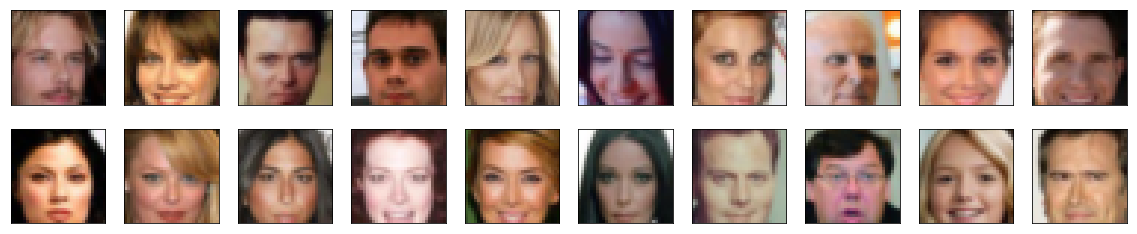

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min_val,max_val = feature_range
    x = x*(max_val - min_val) + min_val
    
    return x


In [8]:

# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.6471)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

####  Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
##Helper function for Conv and Batch Layer of Discriminator##

def conv(in_channels,out_channels,kernel_size=4,stride=2,padding=1,batch_norm = True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels,kernel_size,stride,padding,bias = False)
    
    layers.append(conv_layer)
    
    if batch_norm:
        batch_layer = nn.BatchNorm2d(num_features = out_channels)
        layers.append(batch_layer)
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        
        ## class variables
        self.conv_dim = conv_dim 
        
        ## class layers
        ##self.conv1 = nn.Conv2d(in_channels =3, out_channels=self.conv_dim,kernel_size=4,stride=2,padding=1)##16*16*32
        ##batchNorm1 is not required for the first conv layer
        ##self.conv2 = nn.Conv2d(in_channels = self.conv_dim, out_channels = self.conv_dim*2,kernel_size =4, stride=2,padding =1 )##8*8*64
        ##self.batchnorm2 = nn.BatchNorm2d(num_features = self.conv_dim*2)
        
        ##self.conv3 = nn.Conv2d(in_channels =self.conv_dim*2,out_channels=self.conv_dim*4, kernel_size = 4, stride =2,padding =1)##4*4*128
        ##self.batchnorm3 = nn.BatchNorm2d(self.conv_dim*4)
        
        ##self.conv4 = nn.Conv2d(in_channels =self.conv_dim*4,out_channels=self.conv_dim*8, kernel_size = 4, stride =2,padding =1)##2*2*256
        ##self.batchnorm4 = nn.BatchNorm2d(self.conv_dim*8)     
        
         ## class layers
        self.layer1 = conv(in_channels =3, out_channels=self.conv_dim,kernel_size=4,stride=2,padding=1,batch_norm=False)
        self.layer2 = conv(in_channels = self.conv_dim, out_channels = self.conv_dim*2,kernel_size=4,stride=2,padding=1)
        self.layer3 = conv(in_channels =self.conv_dim*2,out_channels=self.conv_dim*4, kernel_size = 4, stride =2,padding =1)
        self.layer4 = conv(in_channels =self.conv_dim*4,out_channels=self.conv_dim*8, kernel_size = 4, stride =2,padding =1)
        
        self.FC1 = nn.Linear(2*2*self.conv_dim*8,1)
        
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        ##x = self.conv1(x)
        ##x = F.leaky_relu(x)
        ##
        ##x = self.conv2(x)
        ##x = self.batchnorm2(x)
        ##x = F.leaky_relu(x)
        ##
        ##x = self.conv3(x)
        ##x = self.batchnorm3(x)
        ##x = F.leaky_relu(x)
        ##
        ##x = self.conv4(x)
        ##x = self.batchnorm4(x)
        ##x = F.leaky_relu(x)
        ##
#################
        x = self.layer1(x)
        x = F.leaky_relu(x)
        ##
        x = self.layer2(x)
        x = F.leaky_relu(x)
        ##
        x = self.layer3(x)
        x = F.leaky_relu(x)
        ##
        x = self.layer4(x)
        x = F.leaky_relu(x)

        x = x.reshape(-1,2*2*self.conv_dim*8)
        x = self.FC1(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
def deconv(in_channels,out_channels,kernel_size, stride,padding,batch_norm):
    layers = []

    conv_trans_layer = nn.ConvTranspose2d(in_channels,out_channels,kernel_size, stride,padding,bias=False)
    layers.append(conv_trans_layer)
    if batch_norm:
        batch_norm_layer = nn.BatchNorm2d(num_features= out_channels)
        layers.append(batch_norm_layer)
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.z_size = z_size
        self.conv_dim = conv_dim
        
        self.FC1 =    nn.Linear(z_size, conv_dim*8*2*2)

        self.layer1 = deconv(in_channels= conv_dim*8,out_channels= conv_dim*4,kernel_size=4, stride=2,padding=1,batch_norm=True)
        self.layer2 = deconv(in_channels= conv_dim*4,out_channels= conv_dim*2,kernel_size=4, stride=2,padding=1,batch_norm=True)
        self.layer3 = deconv(in_channels= conv_dim*2,out_channels= conv_dim,kernel_size=4, stride=2,padding=1,batch_norm=True)
        self.layer4 = deconv(in_channels= conv_dim,out_channels= 3,kernel_size=4, stride=2,padding=1,batch_norm=False)
        self.tan = nn.Tanh()
        
        ##self.dropout = nn.Dropout(0.3)
        

        
        
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        batch_size = x.shape[0]
        x = self.FC1(x)      ##Here I am generating enough dimension to feed to the con2d Layers 
        x = x.reshape(-1,self.conv_dim*8,2,2)  ## Here I am reshaping into accurate dimension
        assert (x.shape[0] == batch_size)
        
        x = self.layer1(x)
        ##x = F.relu(x)
        x = F.leaky_relu(x)
        ##x = self.dropout(x)
        x = self.layer2(x)
        ##x = F.relu(x)
        x = F.leaky_relu(x)
        ##x = self.dropout(x)
        x = self.layer3(x)
        ##x = F.relu(x)
        x = F.leaky_relu(x)
        ##x = self.dropout(x)
        x = self.layer4(x)
        x = self.tan(x)
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!


#### Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        ##m.weight.data.normal_(0,0.02)
        init.normal_(m.weight.data,0.0,0.02)
        
        ##init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        
        ##init.xavier_normal_(m.weight.data,gain = 0.02)
    
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100


D, G = build_network(d_conv_dim, g_conv_dim, z_size)

train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    D,G = D.cuda(), G.cuda()

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (FC1): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (FC1): Linear(in_features=100, out_features=1024, bias=True)
  (layer1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=F

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:

import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Complete real and fake loss functions

**We may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
from scipy.stats import truncnorm
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

smooth_factor_for_real_loss = get_truncated_normal(mean=.85, sd=.05, low=.8, upp=.95)
print(smooth_factor_for_real_loss.rvs())

smooth_factor_for_fake_loss = get_truncated_normal(mean=.1, sd=0.05, low=0.0, upp=.15)
print(smooth_factor_for_fake_loss.rvs())

0.9217683030449823
0.0958442736836869


In [19]:
def real_loss(D_out,smooth =False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    label_smooth = smooth_factor_for_real_loss.rvs()
    batch_size = D_out.shape[0]
    labels = torch.ones(batch_size)
    if smooth:
        labels = labels*label_smooth
    labels = labels.cuda()
    
    criterion  = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss


##Fake loss smoothing is not used since it is not giving good result
def fake_loss(D_out,smooth = False):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.shape[0]
    label_smooth = smooth_factor_for_fake_loss.rvs()
    if smooth:
        labels = torch.ones(batch_size) ## Using ones and multiplying with a number in range 0.0 to 0.3
        labels = labels*label_smooth
    else:
        labels = torch.zeros(batch_size)
    labels = labels.cuda()
        
    criterion  = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [20]:
import torch.optim as optim

lr = .0002 ##.0001    
beta1=0.5
beta2=0.999 # default value

## Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(),lr, [beta1, beta2])  ##,lr =lr)
#d_optimizer = optim.SGD(D.parameters(),lr, momentum = 0.9)
##d_optimizer = optim.RMSprop(D.parameters(), lr = lr, alpha = 0.9)

g_optimizer = optim.Adam(G.parameters(),lr, [beta1, beta2])   ## ,lr =lr)

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [21]:

X = get_truncated_normal(mean=0, sd=1, low=-1, upp=1)
#X.rvs()

In [22]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    ##fixed_z = np.random.normal(0.0,0.33, size=(sample_size, z_size))
    
    ## a small mean so that most of the values are not zeros
    ##fixed_z = np.random.normal(0.00000,0.33, size=(sample_size, z_size)) 
    
    ##fixed_z = X.rvs(size =(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
        print('Cuda enabled')

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)


            
            # 1. Train the discriminator on real and fake images
            if train_on_gpu:
                real_images = real_images.cuda()
            
            real_output = D(real_images)
            real_output_loss = real_loss(real_output,smooth=True)
            
            z = np.random.uniform(-1,1,size=(batch_size,z_size))
            ##z = np.random.normal(0.00000,0.33, size=(sample_size, z_size)) 
            
            ## a small mean so that most of the values are not zeros
            ##z = np.random.normal(0.0001,0.33, size=(sample_size, z_size)) 
    
            ##z = X.rvs(size =(sample_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            fake_output = D(fake_images)
            fake_output_loss = fake_loss(fake_output,smooth =False)
            
            d_loss = real_output_loss + fake_output_loss
            d_optimizer.zero_grad()
            d_loss.backward()
            ##nn.utils.clip_grad_norm_(d.parameters(), clip=5)
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            z = np.random.uniform(-1,1,size=(batch_size,z_size))
            ##z = np.random.normal(0.0,0.33,size=(batch_size,z_size))
            
            ## a small mean so that most of the values are not zeros
            ##z = np.random.normal(0.00000,0.33, size=(sample_size, z_size))
            
            ##z = X.rvs(size =(sample_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            fake_output_for_g = D(fake_images)
            g_optimizer.zero_grad()
            g_loss = real_loss(fake_output_for_g,smooth =False)
            g_loss.backward()
            ##nn.utils.clip_grad_norm_(g.parameters(), clip=5)
            g_optimizer.step() 
            
            


            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [23]:
# set number of epochs 
n_epochs = 100  ## Best is 50 epochs and lr = .0002

print(train_on_gpu)

# call training function
losses = train(D, G, n_epochs=n_epochs)

True
Cuda enabled
Epoch [    1/  100] | d_loss: 1.4278 | g_loss: 0.8709
Epoch [    1/  100] | d_loss: 0.5805 | g_loss: 4.0982
Epoch [    1/  100] | d_loss: 0.5396 | g_loss: 4.0090
Epoch [    1/  100] | d_loss: 0.7216 | g_loss: 2.0877
Epoch [    1/  100] | d_loss: 0.6655 | g_loss: 2.8216
Epoch [    1/  100] | d_loss: 0.7069 | g_loss: 2.4014
Epoch [    1/  100] | d_loss: 0.7271 | g_loss: 2.9758
Epoch [    1/  100] | d_loss: 1.0868 | g_loss: 3.5416
Epoch [    2/  100] | d_loss: 1.0068 | g_loss: 3.0794
Epoch [    2/  100] | d_loss: 0.6756 | g_loss: 2.6991
Epoch [    2/  100] | d_loss: 0.7821 | g_loss: 2.6465
Epoch [    2/  100] | d_loss: 0.8005 | g_loss: 1.8306
Epoch [    2/  100] | d_loss: 1.0428 | g_loss: 1.5380
Epoch [    2/  100] | d_loss: 0.8008 | g_loss: 2.5660
Epoch [    2/  100] | d_loss: 1.1557 | g_loss: 3.2566
Epoch [    2/  100] | d_loss: 0.7149 | g_loss: 1.8093
Epoch [    3/  100] | d_loss: 0.9140 | g_loss: 2.1841
Epoch [    3/  100] | d_loss: 0.9548 | g_loss: 3.2802
Epoch [   

Epoch [   38/  100] | d_loss: 0.7474 | g_loss: 3.5638
Epoch [   38/  100] | d_loss: 0.5493 | g_loss: 3.1234
Epoch [   39/  100] | d_loss: 0.7739 | g_loss: 4.0972
Epoch [   39/  100] | d_loss: 0.5789 | g_loss: 3.3722
Epoch [   39/  100] | d_loss: 0.7622 | g_loss: 1.4351
Epoch [   39/  100] | d_loss: 0.7206 | g_loss: 2.3569
Epoch [   39/  100] | d_loss: 0.4102 | g_loss: 2.7299
Epoch [   39/  100] | d_loss: 0.6867 | g_loss: 2.0328
Epoch [   39/  100] | d_loss: 0.6083 | g_loss: 2.8849
Epoch [   39/  100] | d_loss: 0.6708 | g_loss: 2.3523
Epoch [   40/  100] | d_loss: 0.5434 | g_loss: 3.0671
Epoch [   40/  100] | d_loss: 0.5190 | g_loss: 4.3769
Epoch [   40/  100] | d_loss: 0.3810 | g_loss: 3.2772
Epoch [   40/  100] | d_loss: 0.9668 | g_loss: 0.9236
Epoch [   40/  100] | d_loss: 0.5851 | g_loss: 3.5927
Epoch [   40/  100] | d_loss: 0.5790 | g_loss: 3.1958
Epoch [   40/  100] | d_loss: 0.6427 | g_loss: 1.6648
Epoch [   40/  100] | d_loss: 0.6134 | g_loss: 2.6267
Epoch [   41/  100] | d_loss

Epoch [   76/  100] | d_loss: 0.4802 | g_loss: 3.1846
Epoch [   76/  100] | d_loss: 0.7006 | g_loss: 3.7881
Epoch [   76/  100] | d_loss: 0.6612 | g_loss: 2.4412
Epoch [   76/  100] | d_loss: 0.5208 | g_loss: 4.3258
Epoch [   77/  100] | d_loss: 1.0490 | g_loss: 4.2027
Epoch [   77/  100] | d_loss: 0.4957 | g_loss: 1.8647
Epoch [   77/  100] | d_loss: 0.8719 | g_loss: 3.3110
Epoch [   77/  100] | d_loss: 0.5625 | g_loss: 4.3946
Epoch [   77/  100] | d_loss: 1.2821 | g_loss: 1.3662
Epoch [   77/  100] | d_loss: 0.6738 | g_loss: 1.1780
Epoch [   77/  100] | d_loss: 0.8752 | g_loss: 3.5113
Epoch [   77/  100] | d_loss: 0.5154 | g_loss: 3.7544
Epoch [   78/  100] | d_loss: 0.6173 | g_loss: 4.7718
Epoch [   78/  100] | d_loss: 0.5986 | g_loss: 3.0787
Epoch [   78/  100] | d_loss: 0.4457 | g_loss: 2.9788
Epoch [   78/  100] | d_loss: 0.5331 | g_loss: 2.6974
Epoch [   78/  100] | d_loss: 0.6499 | g_loss: 2.6516
Epoch [   78/  100] | d_loss: 0.4464 | g_loss: 4.5131
Epoch [   78/  100] | d_loss

In [188]:
##Saving the Generator and the Discrminator

def save_generator(model):
    model_name = 'trained_generator.pt'
    checkpoint = {'z_size' : model.z_size,
                  'conv_dim' : model.conv_dim,
                  'state_dict': model.state_dict()}
    
    with open(model_name, 'wb') as f:
        torch.save(checkpoint,f)
        
def save_discriminator(model):
    model_name = 'trained_discrimiator.pt'
    checkpoint = {'conv_dim' : model.conv_dim,
                  'state_dict': model.state_dict()}
    
    with open(model_name, 'wb') as f:
        torch.save(checkpoint,f)
        
save_generator(G)
save_discriminator(D)

In [100]:
## Function for loading the model

def load_generator():
    with open('trained_generator.pt', 'rb') as f:
        checkpoint = torch.load(f)
    ##model = CharRNN(checkpoint['tokens'],n_hidden =checkpoint['n_hidden'],n_layers=checkpoint['n_layers'])
    G = Generator(checkpoint['z_size'], checkpoint['conv_dim'])
    G.load_state_dict(checkpoint['state_dict'])
    return G

def load_discrimiator():
    with open('trained_discrimiator.pt', 'rb') as f:
        checkpoint = torch.load(f)

    D = Discriminator(checkpoint['conv_dim'])
    D.load_state_dict(checkpoint['state_dict'])
    return D

#G = load_generator()
#D = load_discrimiator()

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

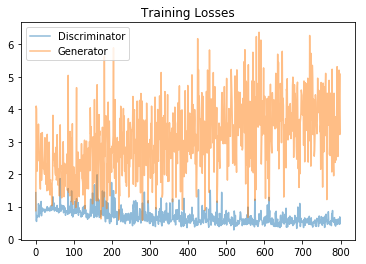

In [24]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [25]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [26]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

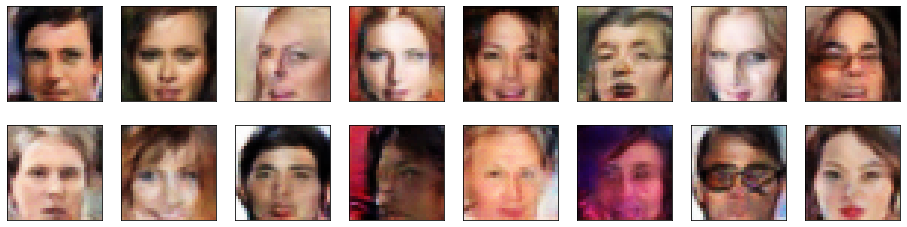

In [32]:
_ = view_samples(-50, samples)  ## 50 epochs gave me the best result